In [1]:
import numpy as np
import intracluster_smote
import evaluation
import matplotlib.pyplot as plt
%matplotlib inline
import mnist_utils
import pandas as pd
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.cluster

# Clustering Algorithms
These algorithms are used to cluster the dataset. Their output will later serve as input to Intracluster SMOTE to generate artificial data.

In [2]:
def kmeans(X,k):
#     if X.shape[0] < 5000: # 10000 recommended
#         return sklearn.cluster.KMeans(n_clusters=k).fit(X).labels_
#     else:
    return sklearn.cluster.MiniBatchKMeans(n_clusters=k).fit(X).labels_

In [3]:
# Define Clustering on Autoencoder Encoding
from keras.callbacks import TensorBoard
# Fixup for keras for Tensorboard > 0.12
import tensorflow as tf
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter
import time
import autoencoder_keras
def autoencoder_kmeans(X,k): 
    ae = autoencoder_keras.Autoencoder(
        layers=[X.shape[1],128,64,32,64,128,X.shape[1]], 
        training_set=X
    )
    ae.fit(train, train,
            nb_epoch=100,
            batch_size=256,
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
    )
    H = ae.encode(X)
    return (H, kmeans(H,k), ae.decode)

Using TensorFlow backend.


In [4]:
# Define Autoencoder Clustering
import autoencoder
def autoencoder_clustering(X,k): 
    # Pretrain using Keras AE
    ae = autoencoder_keras.Autoencoder(
        layers=[X.shape[1],128,64,32,64,128,X.shape[1]], 
        training_set=X
    )
    ae.fit(train, train,
            nb_epoch=100,
            batch_size=256,
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
    )
    # Cluster with clustering AE
    clustering_ae = autoencoder.Autoencoder(
        layers=[X.shape[1],128,64,32,64,128,X.shape[1]], 
        training_set=X
    )
    clustering_ae.set_parameters(ae.get_weights())
    clustering_ae.cluster(epochs=50, eta=0.01, q=0.01, k=k, minibatch_size=256, mu=0.7)
    H = clustering_ae.encode(X)
    return (H, clustering_ae.get_cluster_assignment(X), clustering_ae.decode)

In [5]:
# each of these returns a tuple of (clustering_function, decoder)
preprocessing_methods = {
    'No Oversampling': (lambda X, k: (X, None, None)),
    'No Clustering': (lambda X, k: (X, np.zeros(X.shape[0],), None)),
    'Random Clustering': (lambda X, k: (X, np.random.choice(k, size=(X.shape[0])), None)),
    'K-Means': (lambda X, k: (X, kmeans(X,k), None)),
    'K-Means on Autoencoder Encoding': autoencoder_kmeans,
    'Autoencoder Clustering': autoencoder_clustering
}

# Datasets
Import some datasets to use to test the various data generation methods.

In [6]:
# Import Ecoli Dataset
ecoli_data_raw = pd.read_csv('datasets/ecoli.data.txt', delim_whitespace=True, header=None, names=['Sequence Name','mcg','gvh','lip','chg','aac','alm1','alm2','class'])
ecoli_data_target = ecoli_data_raw['class'].as_matrix()
ecoli_data = ecoli_data_raw.drop(['Sequence Name','class'], axis=1).as_matrix()
ecoli_scaler = sklearn.preprocessing.MinMaxScaler()
ecoli_data = ecoli_scaler.fit_transform(ecoli_data)
ecoli_train, ecoli_validate, ecoli_train_target, ecoli_validate_target = sklearn.model_selection.train_test_split(ecoli_data, ecoli_data_target)

In [7]:
datasets = {
    'MNIST Imbalanced 7+8': {
        'Data': mnist_utils.load_binary_imbalanced(classes=[7,8], ratio=0.2),
        'Imbalance Ratio': 1/5,
        'Minority Class': 8,
        'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]])
    },
    'MNIST Imbalanced 1+7': {
        'Data': mnist_utils.load_binary_imbalanced(classes=[1,7], ratio=0.2),
        'Imbalance Ratio': 1/5,
        'Minority Class': 7,
        'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]])
    },
    'Ecoli': {
        'Data': ((ecoli_train, ecoli_train_target),(ecoli_validate, ecoli_validate_target)),
        'Imbalance Ratio': 1/5.46,
        'Minority Class':'pp',
        'Scaler': ecoli_scaler
    }
}
for name, dataset in datasets.items():
    dataset['Minority Count'] = np.count_nonzero(dataset['Data'][0][1]==dataset['Minority Class'])
    dataset['Majority Count'] = dataset['Data'][0][0].shape[0]-dataset['Minority Count']

# Classifiers
These classifiers need no parameter configuration and lend themselves to benchmarking the effectiveness of data generation methods.

In [8]:
classifiers = {
    'Logistic Regression': sklearn.linear_model.LogisticRegression(),
    'Random Forest': sklearn.ensemble.GradientBoostingClassifier(),
    'Gradient Boosting': sklearn.ensemble.RandomForestClassifier(),
    'Support Vector': sklearn.svm.SVC()
}

# Bringing it all together
Loop through all the datasets and evaluate the performance of the different data balancing techniques using all above classifiers.

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\D059331\.babun\cygwin\home\D059331\development\data\autoencoder\intracluster_smote.py:40: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 41 to 

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true',

Starting training with initial training cost: 0.5025290297503755 and validation cost: 0.5025290297503755
Training Time: 79.17623138427734 Per Epoch ~ 1.5835246276855468


C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_f

Plotting MNIST Imbalanced 1+7 synthetic samples after applying K-Means


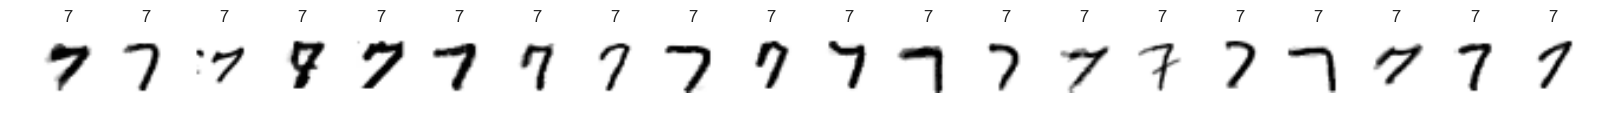

C:\Users\D059331\.babun\cygwin\home\D059331\development\data\autoencoder\intracluster_smote.py:40: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 1348 to 6742.
  warnings.warn(warning_msg)


Plotting MNIST Imbalanced 1+7 synthetic samples after applying No Clustering


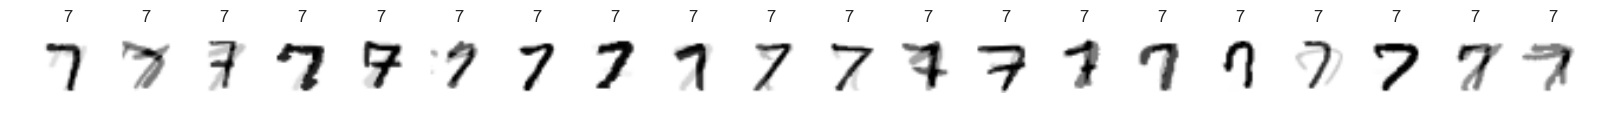

Plotting MNIST Imbalanced 1+7 synthetic samples after applying Random Clustering


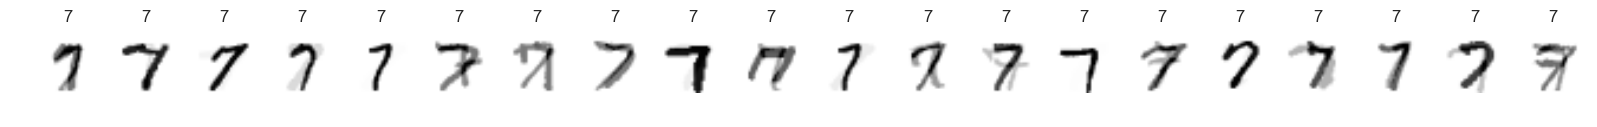

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=3146. Setting it to 3*k
  init_size=init_size)


Reconstruction Quality Sample of Autoencoder K-Means on Autoencoder Encoding


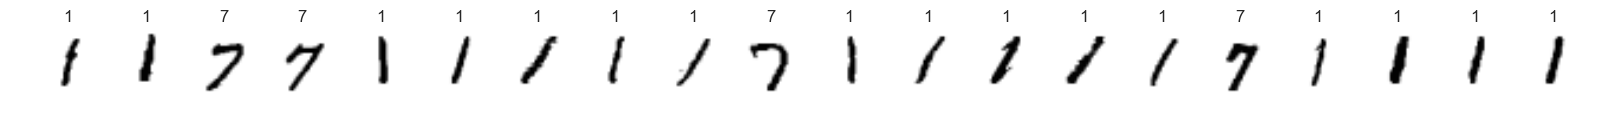

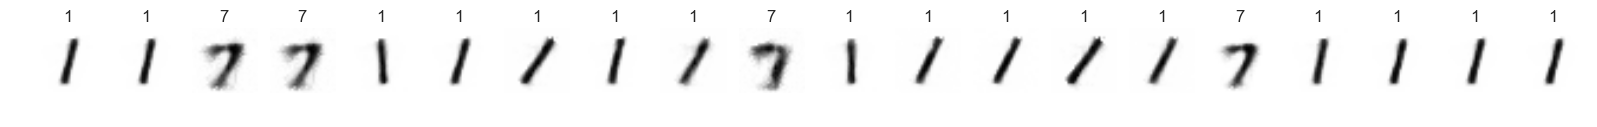

Plotting MNIST Imbalanced 1+7 synthetic samples after applying K-Means on Autoencoder Encoding


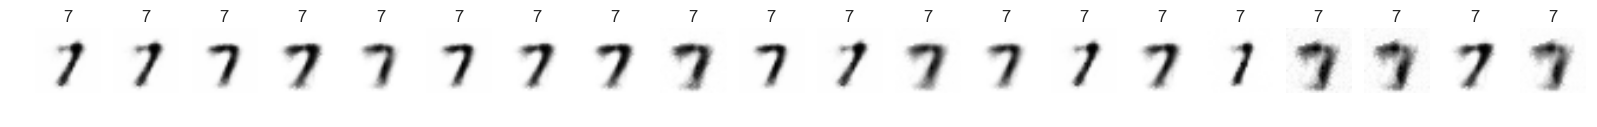

Starting training with initial training cost: 0.13316430303736307 and validation cost: 0.13316430303736307
Training Time: 2784.042507648468 Per Epoch ~ 55.68085015296936
Reconstruction Quality Sample of Autoencoder Autoencoder Clustering


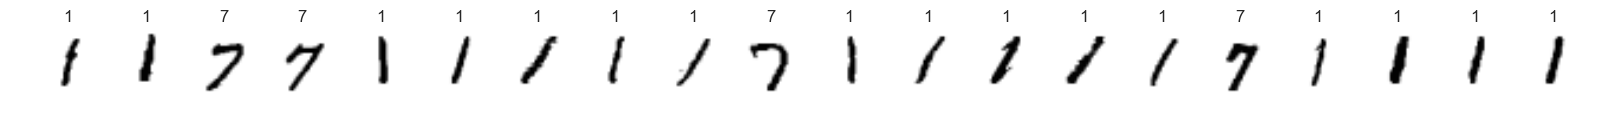

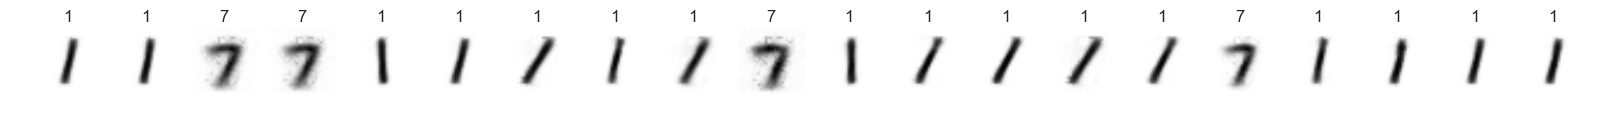

Plotting MNIST Imbalanced 1+7 synthetic samples after applying Autoencoder Clustering


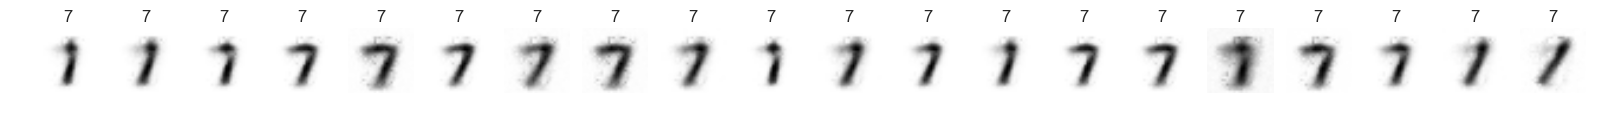

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=2923. Setting it to 3*k
  init_size=init_size)


Plotting MNIST Imbalanced 7+8 synthetic samples after applying K-Means


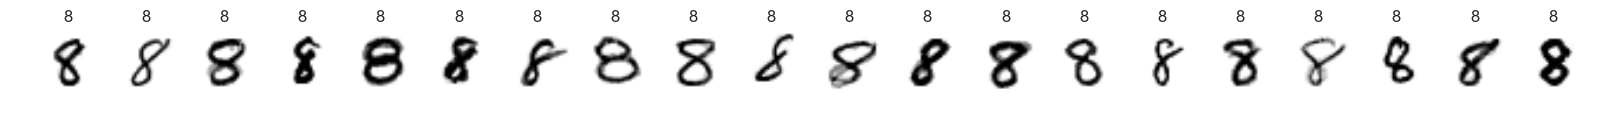

C:\Users\D059331\.babun\cygwin\home\D059331\development\data\autoencoder\intracluster_smote.py:40: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 1253 to 6265.
  warnings.warn(warning_msg)


Plotting MNIST Imbalanced 7+8 synthetic samples after applying No Clustering


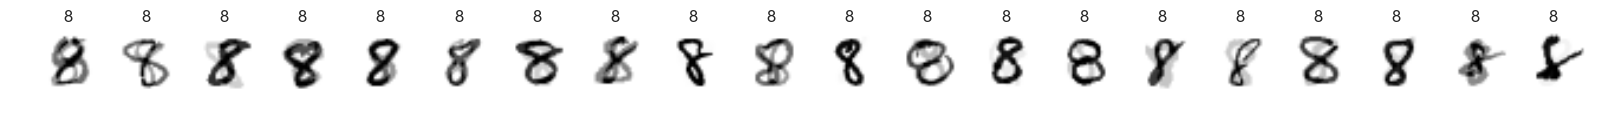

Plotting MNIST Imbalanced 7+8 synthetic samples after applying Random Clustering


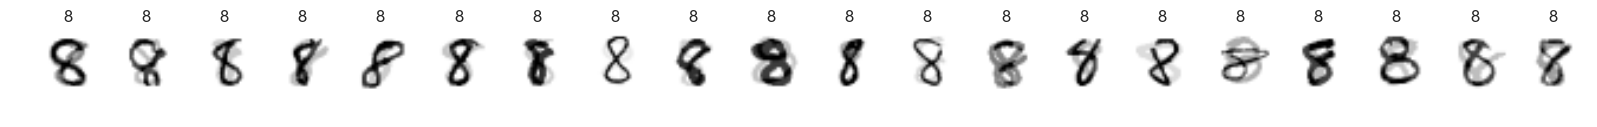

C:\Users\D059331\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=2923. Setting it to 3*k
  init_size=init_size)


Reconstruction Quality Sample of Autoencoder K-Means on Autoencoder Encoding


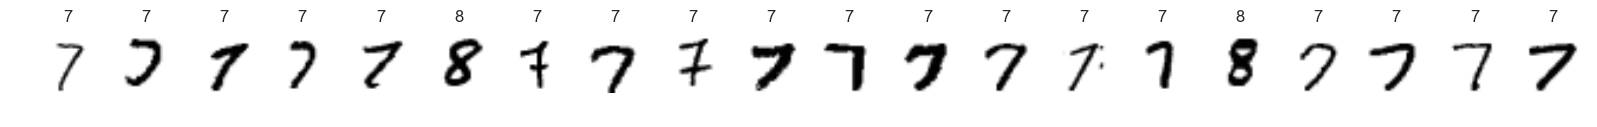

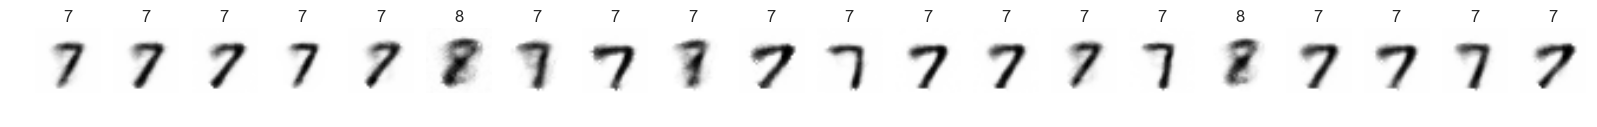

Plotting MNIST Imbalanced 7+8 synthetic samples after applying K-Means on Autoencoder Encoding


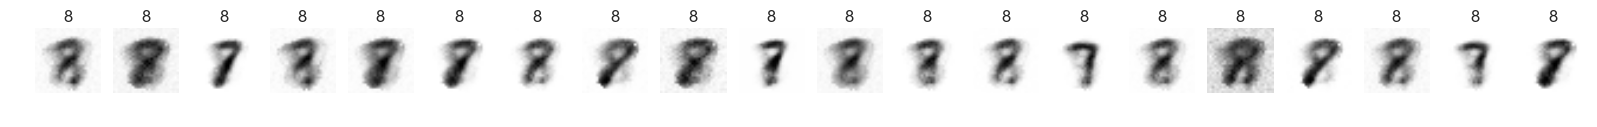

Starting training with initial training cost: 0.20559845802244409 and validation cost: 0.20559845802244409
Validation set performance has been unchanged or decreasing for 15 epochs. Stopping training.
Training Time: 523.4431018829346 Per Epoch ~ 10.468862037658692
Reconstruction Quality Sample of Autoencoder Autoencoder Clustering


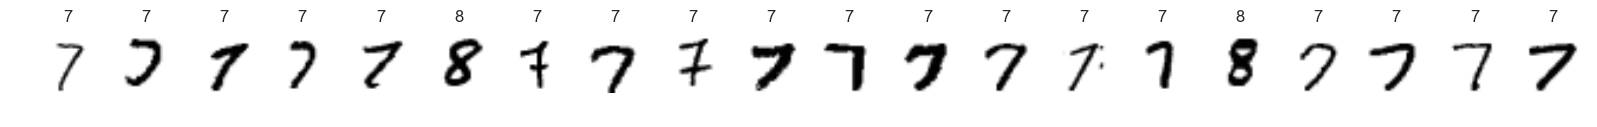

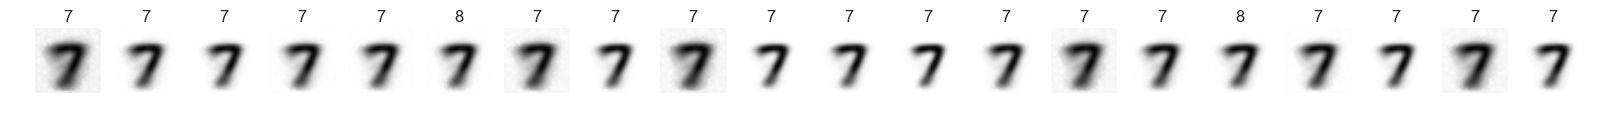

Plotting MNIST Imbalanced 7+8 synthetic samples after applying Autoencoder Clustering


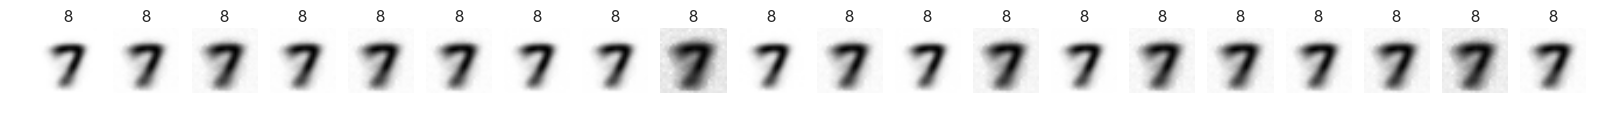

Balanced F-Measure  \
Dataset              Oversampling                    Classifier                                
Ecoli                Autoencoder Clustering          Gradient Boosting              0.263293   
                                                     Logistic Regression            0.171807   
                                                     Random Forest                  0.195424   
                                                     Support Vector                 0.038596   
                     K-Means                         Gradient Boosting              0.838024   
                                                     Logistic Regression            0.377970   
                                                     Random Forest                  0.590999   
                                                     Support Vector                 0.406689   
                     K-Means on Autoencoder Encoding Gradient Boosting              0.238386   
                                                     Logistic Regression            0.040293   
                                                     Random Forest                  0.245307   
                                                     Support Vector                 0.038596   
                     No Clustering                   Gradient Boosting              0.621804   
                                                     Logistic Regression            0.402764   
                                                     Random Forest                  0.696719   
                                                     Support Vector                 0.399273   
                     No Oversampling                 Gradient Boosting              0.809158   
                                                     Logistic Regression            0.753153   
                                                     Random Forest                  0.718458   
                                                     Support Vector                 0.432245   
                     Random Clustering               Gradient Boosting              0.837586   
                                                     Logistic Regression            0.391206   
                                                     Random Forest                  0.718458   
                                                     Support Vector                 0.413955   
MNIST Imbalanced 1+7 Autoencoder Clustering          Gradient Boosting              0.623432   
                                                     Logistic Regression            0.934947   
                                                     Random Forest                  0.577753   
                                                     Support Vector                 0.970279   
                     K-Means                         Gradient Boosting              0.993333   
                                                     Logistic Regression            0.990700   
...                                                                                      ...   
                     No Oversampling                 Random Forest                  0.993333   
                                                     Support Vector                 0.990633   
                     Random Clustering               Gradient Boosting              0.987913   
                                                     Logistic Regression            0.992014   
                                                     Random Forest                  0.990633   
                                                     Support Vector                 0.991985   
MNIST Imbalanced 7+8 Autoencoder Clustering          Gradient Boosting              0.522997   
                                                     Logistic Regression            0.519394   
                                                     Random Forest                  0.454425   
                                          

In [9]:
classification_evaulation = {}
for dataset_name, dataset in datasets.items():
#     if dataset_name != 'Ecoli':continue
    (train, train_target), (test, test_target) = dataset['Data']
    for preprocessing_method_name, preprocessing_method in preprocessing_methods.items():        
        if preprocessing_method_name == 'No Oversampling':
            (train_oversampled, train_target_oversampled) = train, train_target
        else:
            #oversample
            try:
                k = dataset['Minority Count']+((dataset['Majority Count']-dataset['Minority Count'])//3)
                train_encoded, cluster_labels, decoder = preprocessing_method(train, k)
                required_synthetic_count =  intracluster_smote.compute_synthetic_count(train.shape[0], dataset['Imbalance Ratio'])
                oversampler = intracluster_smote.IntraclusterSmote(required_synthetic_count, decoder=decoder)
                (train_oversampled, train_target_oversampled), (synth_X, synth_y) = oversampler.fit_transform(train_encoded, train_target, dataset['Minority Class'], cluster_labels)
                if dataset_name.startswith('MNIST'):
                    if preprocessing_method_name.rfind('Autoencoder') > -1:
                        print('Reconstruction Quality Sample of Autoencoder', preprocessing_method_name)
                        mnist_utils.plot_mnist(train, train_target, 20)
                        mnist_utils.plot_mnist(decoder(train_encoded), train_target, 20)
                    print('Plotting', dataset_name, 'synthetic samples after applying', preprocessing_method_name)
                    mnist_utils.plot_mnist(synth_X, synth_y, 20)
            except Exception as e:
                print('Exception occured at', preprocessing_method_name)
                print(str(e))
        for classifier_name, classifier in classifiers.items():
            # classify
            classifier.fit(train_oversampled,train_target_oversampled)
            prediction = classifier.predict(test)
            #evaluate
            classification_evaulation[(dataset_name,preprocessing_method_name,classifier_name)] = evaluation.evaluate_classification(prediction, test_target)

res = pd.DataFrame(classification_evaulation).transpose()
res.index.names = (['Dataset', 'Oversampling', 'Classifier'])
res.to_csv('results/{0}.csv'.format(time.asctime().replace(":","h",1).replace(":","m",1)))
display(res)

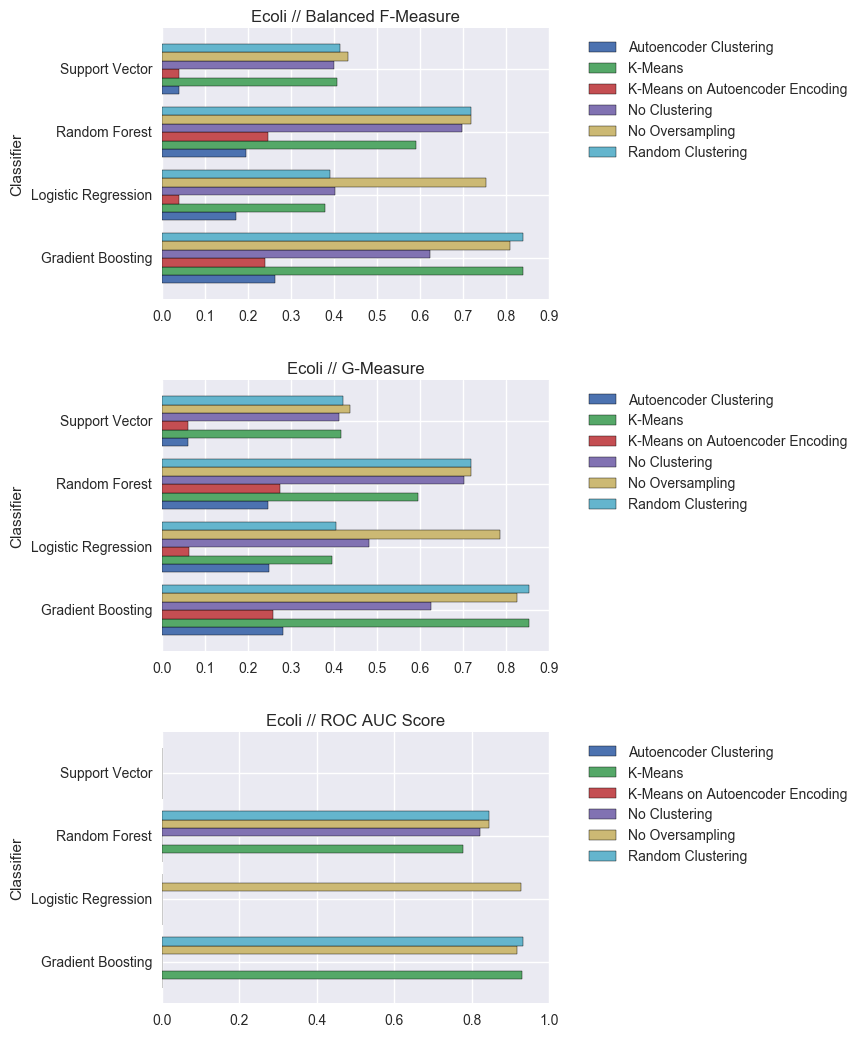

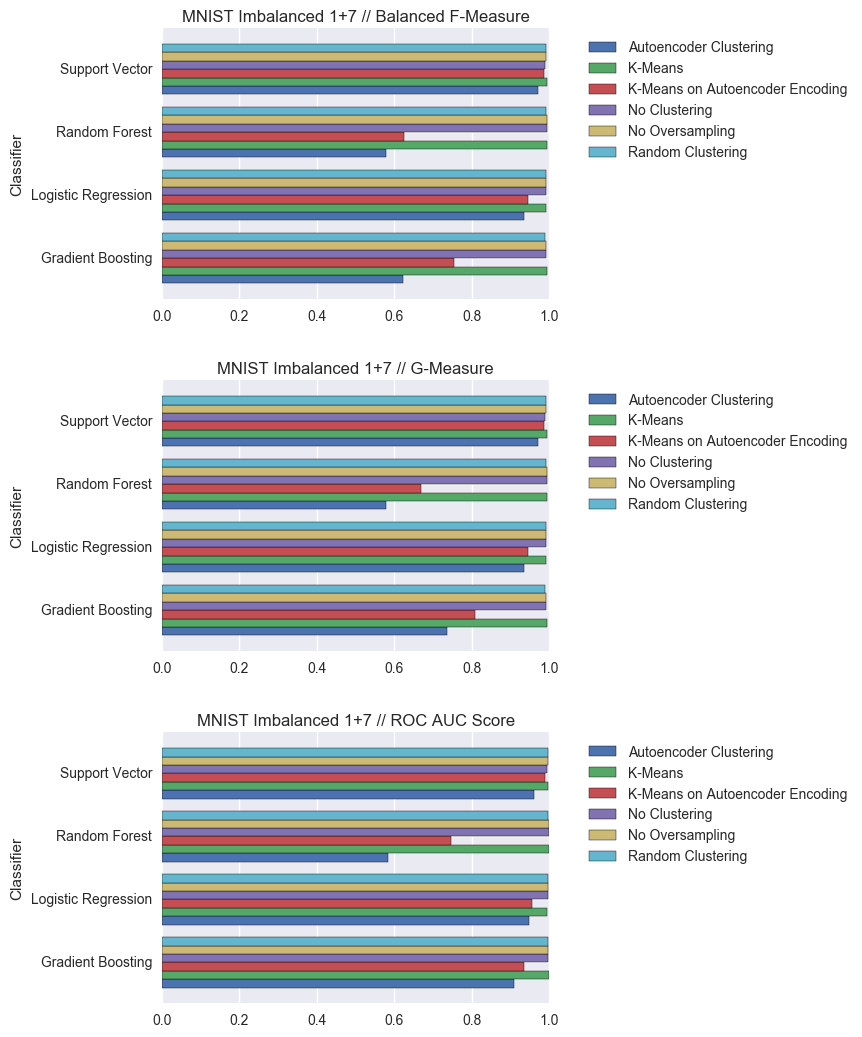

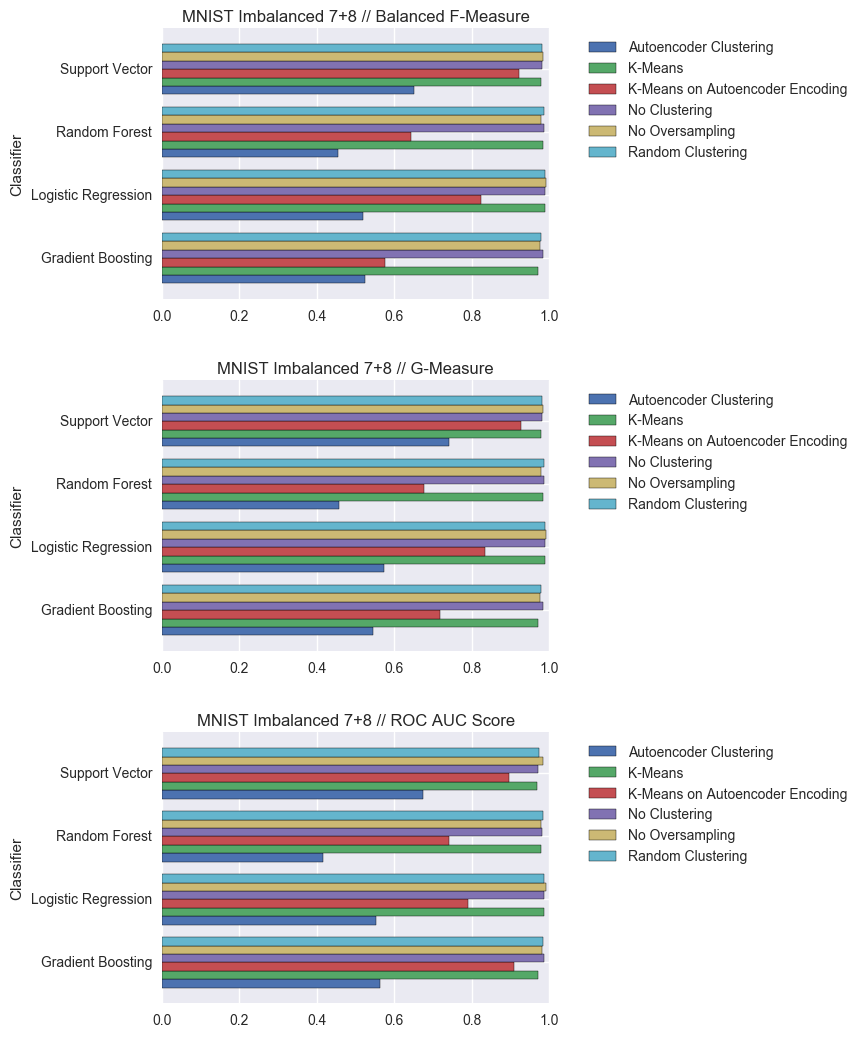

In [10]:
for dataset in res.index.levels[0].values:
    fig, axes = plt.subplots(nrows=len(res.columns), ncols=1)#, subplot_kw={'hspace':2})
    fig.subplots_adjust(top=5, hspace=0.3)
    for i, score in enumerate(res.columns):
        ax=axes[i]
        ax.set_title(dataset + ' // ' + score)
        unstacked_res = res[score][dataset].unstack(level=0)
        unstacked_res.plot(kind='barh',ax=ax, figsize=(5,2), width=.8)
        ax.legend(bbox_to_anchor=(1.8, 1))